# **Clasificación**

### En este archivo trataremos con diferentes modelos de clasificación para predecir el ganador del torneo de fútbol de esta temporada 23-24.

Comenzamos importando todas las dependecias necesarias para el correcto funcionamiento del documento.

In [ ]:
# Importamos librerías

# Visualización de datos
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Manipulación de datos
import pandas as pd
import numpy as np

# Preparación de los datos
from sklearn.preprocessing import scale, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# Modelos de predicción
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier

# Métricas de evaluación
from sklearn.metrics import accuracy_score, classification_report

El siguiente paso es importar los datos con lo que vamos a trabajar.

In [143]:
partidos = pd.read_csv('../../data/partidos_limpio.csv')
partidos.head()

,Season,Round,Day,Date,Results,Home,Country (Home),Points (Home),Score (Home),Score (Away),...,MP_away,Starts_away,Gls_away,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away
0,2023-2024,Round of 16,Tue,2024-02-13,A,RB Leipzig,Germany,88.736698,0,1,...,10.0,110.0,20.0,17.0,37.0,20.0,0.0,1.0,18.0,0.0
1,2023-2024,Round of 16,Tue,2024-02-13,A,FC Copenhagen,Denmark,80.431647,1,3,...,10.0,110.0,28.0,20.0,48.0,25.0,3.0,3.0,10.0,0.0
2,2023-2024,Round of 16,Wed,2024-02-14,H,Paris S-G,France,114.334580,2,0,...,8.0,88.0,8.0,5.0,13.0,8.0,0.0,1.0,18.0,0.0
3,2023-2024,Round of 16,Wed,2024-02-14,H,Lazio,Italy,99.943311,1,0,...,10.0,110.0,18.0,14.0,32.0,16.0,2.0,2.0,13.0,1.0
4,2023-2024,Round of 16,Tue,2024-02-20,D,PSV Eindhoven,The Netherlands,98.784903,1,1,...,10.0,110.0,15.0,12.0,27.0,14.0,1.0,1.0,16.0,0.0


### Preparación de los datos.

Queremos columnas numéricas para nuestra predicción, así que pasaremos todas aquellas columnas categóricas a numéricas usando Label Encoder. Además guardamos estas transformaciones en un diccionario que llamamos 'mapping' para poder posteriormente deshacer los cambios con facilidad. 

La única columna no numérica que no cambiaremos será la columna 'Results' ya que esa será nuestra variable objetivo (y) y podemos dejarla como categórica.

In [144]:
# Columnas a modificar
cols = ['Season', 'Round', 'Day', 'Date', 'Home', 'Away', 'Country (Home)', 'Country (Away)', 'Venue', 'Referee', 'Year', 'Month', 'Number Day']

# Inicializamos el label encoder
label_encoder = LabelEncoder()

# Creamos un diccionario para guardar los mapeos de valores escalados
mapping = {}

# Transformamos la columna 'Date' a datetime
partidos['Date'] = pd.to_datetime(partidos['Date'])

# Iteramos sobre las columnas y las transformamos
for col in cols:
    # Si la columna es de tipo datetime, la transformamos a año, mes y día
    if col == 'Date':
        partidos['Year'] = partidos['Date'].dt.year
        partidos['Month'] = partidos['Date'].dt.month
        partidos['Number Day'] = partidos['Date'].dt.day
        continue
    
    # Guardamos los valores únicos originales antes de la transformación
    unique_values = partidos[col].unique()
    
    # Transformamos los valores usando LabelEncoder
    label_encoder.fit(unique_values)
    partidos[col] = label_encoder.transform(partidos[col])
    
    # Escalamos los valores transformados
    partidos[col] = scale(partidos[col])
        
    # Creamos un mapeo de los valores escalados con las clases del LabelEncoder como claves
    mapping[col] = dict(zip(unique_values, partidos[col].unique()))

# Eliminamos la columna 'Date'
partidos.drop('Date', axis=1, inplace=True)

# Verificamos los cambios
partidos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 598 entries, 0 to 597
Data columns (total 41 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Season          598 non-null    float64
 1   Round           598 non-null    float64
 2   Day             598 non-null    float64
 3   Results         598 non-null    object 
 4   Home            598 non-null    float64
 5   Country (Home)  598 non-null    float64
 6   Points (Home)   598 non-null    float64
 7   Score (Home)    598 non-null    int64  
 8   Score (Away)    598 non-null    int64  
 9   Points (Away)   598 non-null    float64
 10  Country (Away)  598 non-null    float64
 11  Away            598 non-null    float64
 12  Venue           598 non-null    float64
 13  Referee         598 non-null    float64
 14  # Pl_home       540 non-null    float64
 15  Age_home        540 non-null    float64
 16  MP_home         540 non-null    float64
 17  Starts_home     540 non-null    flo

Eliminamos las filas con datos nulos.

In [145]:
partidos = partidos.dropna()

Ahora ya definimos nuestras variables para las predicciones. En nuestro caso, queremos predecir los resultados del partido, por lo que querremos predecir la columna 'Results'.

Eliminamos además las columnas 'Score (Home)' y 'Score (Away)' ya que en las predicciones nunca tendremos los resultados del partido, por lo que no tiene sentido entrenar los modelos con estas dos columnas. También eliminamos la columna 'Referee' ya que a la hora de predecir un partido tampoco sabremos quién será el árbitro del mismo.

In [146]:
X = partidos.drop(labels=['Results', 'Score (Home)', 'Score (Away)', 'Referee'], axis=1)
y = partidos['Results']

# Estandarizamos los datos

# Columnas a estandarizar
cols = [['Points (Home)', 'Points (Away)', '# Pl_home','Age_home','MP_home','Starts_home','Gls_home','Ast_home','G+A_home','G-PK_home','PK_home','PKatt_home','CrdY_home','CrdR_home','# Pl_away','Age_away','MP_away','Starts_away','Gls_away','Ast_away','G+A_away','G-PK_away','PK_away','PKatt_away','CrdY_away','CrdR_away']]

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    X[col] = scale(X[col])

Separamos en train y test las variables que usaremos para entrenar nuestros modelos.

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

### Modelos de predicción.

Comenzamos con la Regresión Logística.

In [148]:
lr = LogisticRegression(C=0.1, penalty='l2', solver='liblinear', max_iter=1000, random_state=42)
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)

Seguimos con SVC (Support Vector Classification).

In [149]:
svc = SVC(random_state=912, kernel='sigmoid')
svc.fit(X_train, y_train)
svc_pred = svc.predict(X_test)

Nuestro último modelo de clasificación será XGBoost.

In [150]:
xgb = GradientBoostingClassifier(random_state=912)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

### Métricas de evaluación.

Para hacer estas métricas, haremos uso del informe de clasificación (Classification Report), una tabla que resume las métricas de evaluación del rendimiento de un modelo de clasificación en un conjunto de datos de prueba. 

¿Qué métricas aparecen en este informe?

- Precision (Precisión): La precisión indica la proporción de instancias clasificadas como positivas que son verdaderamente positivas. Se calcula como el número de verdaderos positivos dividido por el número total de predicciones positivas (verdaderos positivos más falsos positivos).

- Recall (Recuperación o Sensibilidad): El recall indica la proporción de instancias positivas que fueron correctamente clasificadas. Se calcula como el número de verdaderos positivos dividido por el número total de instancias positivas (verdaderos positivos más falsos negativos).

- F1-score (Puntaje F1): Es la media armónica de la precisión y el recall. Proporciona un equilibrio entre precisión y recall. Se calcula como 2 * (precision * recall) / (precision + recall).

- Support (Soporte): Es el número de muestras verdaderas que pertenecen a cada clase en el conjunto de datos de prueba.

- Accuracy (Exactitud): Es la proporción de muestras correctamente clasificadas entre todas las muestras. Se calcula como el número de muestras correctamente clasificadas dividido por el número total de muestras.

- Macro average (Promedio Macro): Es el promedio sin ponderar de las métricas para cada clase. Calcula las métricas independientemente para cada clase y luego toma el promedio sin tener en cuenta el desequilibrio en el tamaño de las clases.

- Weighted average (Promedio Ponderado): Es el promedio ponderado de las métricas para cada clase, donde cada clase contribuye con su peso relativo al número total de muestras en el conjunto de datos de prueba.

In [151]:
print("\nMétricas Regresión Logística:")
print("Precisión:", accuracy_score(y_test, lr_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, lr_pred, zero_division=0))


Métricas Regresión Logística:
Precisión: 0.6049382716049383
Informe de Clasificación:
              precision    recall  f1-score   support

           A       0.56      0.54      0.55        46
           D       0.27      0.09      0.13        35
           H       0.66      0.86      0.75        81

    accuracy                           0.60       162
   macro avg       0.50      0.50      0.48       162
weighted avg       0.55      0.60      0.56       162



In [152]:
print("\nMétricas SVC:")
print("Precisión:", accuracy_score(y_test, svc_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, svc_pred, zero_division=0))


Métricas SVC:
Precisión: 0.6234567901234568
Informe de Clasificación:
              precision    recall  f1-score   support

           A       0.60      0.61      0.60        46
           D       0.12      0.03      0.05        35
           H       0.67      0.89      0.77        81

    accuracy                           0.62       162
   macro avg       0.46      0.51      0.47       162
weighted avg       0.53      0.62      0.56       162



In [153]:
print("\nMétricas XGBoost:")
print("Precisión:", accuracy_score(y_test, xgb_pred))
print("Informe de Clasificación:")
print(classification_report(y_test, xgb_pred, zero_division=0))


Métricas XGBoost:
Precisión: 0.5864197530864198
Informe de Clasificación:
              precision    recall  f1-score   support

           A       0.56      0.41      0.47        46
           D       0.26      0.17      0.21        35
           H       0.67      0.86      0.75        81

    accuracy                           0.59       162
   macro avg       0.50      0.48      0.48       162
weighted avg       0.55      0.59      0.56       162



### Predicciones

Ahora hagamos las predicciones de los partidos que aún quedan por jugar.

#### Semifinales

In [154]:
# Definimos una lista llamada 'semis' que contiene datos de partidos de fútbol de las semifinales
semis = [['2023-2024', 'Semi-finals', 'Tue', 'Bayern Munich', 'Germany', 107.882298136646, 114.5545351473923, 'Spain', 'Real Madrid', 'Allianz Arena', 23, 28.3, 10, 110, 18, 14, 32, 16, 2, 2, 13.0, 1.0, 22, 28.0, 10, 110, 20, 17, 37, 20, 0, 1, 18.0, 0.0, 2024, 4, 30],
        ['2023-2024', 'Semi-finals', 'Wed', 'Dortmund', 'Germany', 91.17303312629399, 114.33458049886625, 'France', 'Paris S-G', 'Signal Iduna Park', 23, 28.0, 10, 110, 15, 12, 27, 14, 1, 1, 16.0, 0.0, 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 2024, 5, 1],
        ['2023-2024', 'Semi-finals', 'Tue', 'Paris S-G', 'France', 114.33458049886625, 91.17303312629399, 'Germany', 'Dortmund', 'Parc des Princes', 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 23, 28.0, 10, 110, 15, 12, 27, 14, 1, 1, 16.0, 0.0, 2024, 5, 7],
        ['2023-2024', 'Semi-finals', 'Wed', 'Real Madrid', 'Spain', 114.5545351473923, 107.882298136646, 'Germany', 'Bayern Munich', 'Estadio Santiago Bernabéu', 22, 28.0, 10, 110, 20, 17, 37, 20, 0, 1, 18.0, 0.0, 23, 28.3, 10, 110, 18, 14, 32, 16, 2, 2, 13.0, 1.0, 2024, 5, 8]]

# Obtenemos las columnas relevantes del DataFrame 'partidos' para usar como nombres de columnas en el DataFrame 'semis'
partidos_cols = partidos.drop(labels=['Results', 'Score (Home)', 'Score (Away)', 'Referee'], axis=1).columns

# Creamos un DataFrame 'semis' a partir de la lista 'semis' con las columnas obtenidas del DataFrame 'partidos'
semis = pd.DataFrame(semis, columns=(partidos_cols))

semis.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,2023-2024,Semi-finals,Tue,Bayern Munich,Germany,107.882298,114.554535,Spain,Real Madrid,Allianz Arena,...,17,37,20,0,1,18.0,0.0,2024,4,30
1,2023-2024,Semi-finals,Wed,Dortmund,Germany,91.173033,114.334580,France,Paris S-G,Signal Iduna Park,...,12,31,16,3,3,27.0,0.0,2024,5,1
2,2023-2024,Semi-finals,Tue,Paris S-G,France,114.334580,91.173033,Germany,Dortmund,Parc des Princes,...,12,27,14,1,1,16.0,0.0,2024,5,7
3,2023-2024,Semi-finals,Wed,Real Madrid,Spain,114.554535,107.882298,Germany,Bayern Munich,Estadio Santiago Bernabéu,...,14,32,16,2,2,13.0,1.0,2024,5,8


Ahora, para poder aplicar nuestros modelos a estos nuevos datos, debemos convertirlos a numéricos. Para ello, aplicamos el mismo mapping que usamos anteriormente.

In [155]:
data = semis.copy()

# Aplicamos mapping a las columnas
for col, col_mapping in mapping.items():
    if col in data.columns:
        data[col] = data[col].map(col_mapping)
    else:
        if col == 'Squad':
            data['Home'] = data['Home'].map(col_mapping)
            data['Away'] = data['Away'].map(col_mapping)
        elif col == 'Country':
            data['Country (Home)'] = data['Country (Home)'].map(col_mapping)
            data['Country (Away)'] = data['Country (Away)'].map(col_mapping)

data.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,1.687752,1.722443,-0.467463,-1.175076,-0.495540,107.882298,114.554535,1.257957,1.181904,-1.456509,...,17,37,20,0,1,18.0,0.0,1.687752,0.652616,2.093434
1,1.687752,1.722443,0.753248,-0.685127,-0.495540,91.173033,114.334580,-0.776745,0.909543,0.748021,...,12,31,16,3,3,27.0,0.0,1.687752,1.568730,-1.805646
2,1.687752,1.722443,-0.467463,0.893597,-0.786919,114.334580,91.173033,-0.486073,-0.670156,0.573979,...,12,27,14,1,1,16.0,0.0,1.687752,1.568730,-0.998940
3,1.687752,1.722443,0.753248,1.165790,1.252736,114.554535,107.882298,-0.486073,-1.160407,-0.615307,...,14,32,16,2,2,13.0,1.0,1.687752,1.568730,-0.864489


Escalamos las columnas que no se han modificado con el mapeo.

In [156]:
# Columnas a estandarizar
cols = ['Points (Home)', 'Points (Away)', '# Pl_home','Age_home','MP_home','Starts_home','Gls_home','Ast_home','G+A_home','G-PK_home','PK_home','PKatt_home','CrdY_home','CrdR_home','# Pl_away','Age_away','MP_away','Starts_away','Gls_away','Ast_away','G+A_away','G-PK_away','PK_away','PKatt_away','CrdY_away','CrdR_away']

# Se recorren las columnas especificadas y se escala cada una
for col in cols:
    data[col] = scale(data[col])

data.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,1.687752,1.722443,-0.467463,-1.175076,-0.495540,0.094187,0.795424,1.257957,1.181904,-1.456509,...,1.588203,1.473911,1.605910,-1.341641,-0.904534,-0.095783,-0.577350,1.687752,0.652616,2.093434
1,1.687752,1.722443,0.753248,-0.685127,-0.495540,-1.661918,0.772307,-0.776745,0.909543,0.748021,...,-0.855186,-0.210559,-0.229416,1.341641,1.507557,1.628305,-0.577350,1.687752,1.568730,-1.805646
2,1.687752,1.722443,-0.467463,0.893597,-0.786919,0.772307,-1.661918,-0.486073,-0.670156,0.573979,...,-0.855186,-1.333539,-1.147079,-0.447214,-0.904534,-0.478913,-0.577350,1.687752,1.568730,-0.998940
3,1.687752,1.722443,0.753248,1.165790,1.252736,0.795424,0.094187,-0.486073,-1.160407,-0.615307,...,0.122169,0.070186,-0.229416,0.447214,0.301511,-1.053609,1.732051,1.687752,1.568730,-0.864489


Hacemos nuestras predicciones de las semifinales de este torneo

In [157]:
lr_pred_actual = lr.predict(data)
svc_pred_actual = svc.predict(data)
xgb_pred_actual = xgb.predict(data)

Para visualizar los resultados haremos un DataFrame nuevo. Para crear este nuevo DataFrame haremos 4 listas: cada una corresponde a una columna del nuevo DataFrame.

In [158]:
X_home = semis['Home'].tolist()
X_away = semis['Away'].tolist()
lr_pred_lst = lr_pred_actual.tolist()
svc_pred_lst = svc_pred_actual.tolist()
xgb_pred_lst = xgb_pred_actual.tolist()

# Se crea un DataFrame con los valores obtenidos
res = pd.DataFrame({'Home': X_home, 'Away': X_away, 'LR': lr_pred_lst, 'SVC': svc_pred_lst, 'XGB': xgb_pred_lst})

# Mostrar los resultados
res

,Home,Away,LR,SVC,XGB
0,Bayern Munich,Real Madrid,A,A,H
1,Dortmund,Paris S-G,H,H,D
2,Paris S-G,Dortmund,H,H,H
3,Real Madrid,Bayern Munich,H,H,D


El modelo XGBoost nos muestra que los claros finalistas del torneo son Bayern Munich vs Paris S-G. Por otro lado, Regresión Logística (LR) y SVC nos muestran tan solo un finalista: Real Madrid, el otro finalista no está decidido.

No queda claro qué equipos pasarían a la siguiente ronda. Por lo tanto, estudiaremos las probabilidades que se han obtenido a la hora de hacer las predicciones. 

Es decir, el modelo hace una predicción porque, por ejemplo, la opción 'A' le ha salido con un 90% de probabilidad y las otras dos opciones con menor probabilidad. Basándose en estos datos, en la pantalla se muestra aquella opción con mayor probabilidad, en el caso que hemos visto, se monstraría 'A' como predicción. Nosotros analizaremos estas predicciones y el equipo que tenga mayor probabilidad de ganar pasa a la siguiente ronda.

In [159]:
# Predicción de probabilidades para Regresión Logística (lr)
lr_pred_prob = lr.predict_proba(data)

# Predicción de probabilidades para SVC (svc)
# Calcular las puntuaciones de decisión para SVC (svc)
svc_decision_scores = svc.decision_function(data)
# Convertir las puntuaciones en probabilidades usando la función sigmoide
svc_pred_prob = 1 / (1 + np.exp(-svc_decision_scores))

# Crear un diccionario con las probabilidades de cada modelo
pred_probs = {}

# Se obtienen las claves, que corresponden a los valores únicos de 'y' (variable objetivo)
pred_probs_keys = y.unique()

# Se recorren las claves y se obtienen las probabilidades de cada modelo
for key in pred_probs_keys:
    pred_probs[key] = []
    for i in range(len(lr_pred_prob)):
        # Asumimos que el orden de las clases 'y' es el mismo que el de sus predicciones
        # Se obtiene el índice de la clave en el array de claves
        x = np.where(pred_probs_keys == key)[0][0]
        # Se añaden las probabilidades de cada modelo a la lista de la clave correspondiente
        pred_probs[key].append([lr_pred_prob[i][x], svc_pred_prob[i][x]])

Una vez obtenidas las probabilidades, agregamos las más relevantes a nuestra tabla de resultados (sin tener en cuenta la columna XGB ya que de ese modelo ya hemos visto cuales son sus finalistas).

In [160]:
# Eliminamos la columna 'XGB' del DataFrame 'res'
res.drop('XGB', axis=1, inplace=True)

# Iterar sobre las filas y columnas del DataFrame 'res'
for index, row in res.iterrows():
    for col in ['LR', 'SVC']:  # Iterar sobre las columnas LR, SVC y XGB
        col_index = ['LR', 'SVC'].index(col)
        # Obtener el valor de 'key' basado en el valor en la columna 'col'
        key = row[col]
        # Obtener el valor asociado de 'pred_probs' para la fila 'index' y columna 'key'
        value = pred_probs[key][index]
        value = value[col_index]
        # Actualizar la celda en el DataFrame con el valor 'L: value'
        res.at[index, col] = f"{key}: {value}"

# Mostrar los resultados actualizados
res

,Home,Away,LR,SVC
0,Bayern Munich,Real Madrid,A: 0.6163108356772823,A: 0.9039878411388932
1,Dortmund,Paris S-G,H: 0.1130341370695172,H: 0.443887233239153
2,Paris S-G,Dortmund,H: 0.18365836008991554,H: 0.69279539714842
3,Real Madrid,Bayern Munich,H: 0.19824758280066906,H: 0.700338815325257


Nuestro modelo SVC nos muestra que en un partido gana el Dortmund con un 44% de probabilidad y en el otro partido gana en Paris S-G con un 69%. Por lo tanto, podemo admitir que el finalista de este modelo es el Paris S-G.

Por último, lo mismo sucede en la Regresión Logística, las probabilidades de que gane el Paris S-G son mayores que las probabilidades de que gane el Dortmund, siendo finalista el Paris S-G.

Por lo tanto, concluimos que nuestros modelos de clasificación nos dan dos finales distintas:

1º Real Madrid vs Paris S-G.

2º Bayern Munich vs Paris S-G.

#### Final

Creamos DataFrames de las dos posibles finales.

In [161]:
final1 = [['2023-2024', 'Final', 'Sat', 'Real Madrid', 'Spain', 114.5545351473923, 114.33458049886625, 'France', 'Paris S-G', 'Wembley Stadium', 22, 28.0, 10, 110, 20, 17, 37, 20, 0, 1, 18.0, 0.0, 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 2024, 6, 1]]
final1 = pd.DataFrame(final1, columns=(partidos_cols))

final1.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,2023-2024,Final,Sat,Real Madrid,Spain,114.554535,114.33458,France,Paris S-G,Wembley Stadium,...,12,31,16,3,3,27.0,0.0,2024,6,1


In [162]:
final2 = [['2023-2024', 'Final', 'Sat', 'Bayern Munich', 'Germany', 107.882298136646, 114.33458049886625, 'France', 'Paris S-G', 'Wembley Stadium', 23, 28.3, 10, 110, 18, 14, 32, 16, 2, 2, 13.0, 1.0, 21, 25.3, 10, 110, 19, 12, 31, 16, 3, 3, 27.0, 0.0, 2024, 6, 1]]
final2 = pd.DataFrame(final2, columns=(partidos_cols))

final2.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,2023-2024,Final,Sat,Bayern Munich,Germany,107.882298,114.33458,France,Paris S-G,Wembley Stadium,...,12,31,16,3,3,27.0,0.0,2024,6,1


Generamos dos sets de datos dependiendo de la final jugada y tranformamos las columnas a numéricas usando el mismo mapping. También escalamos dos datos que no se modificaron tras el mapeo.

In [163]:
data1 = final1.copy()

# Aplicamos mapping a las columnas
for col, col_mapping in mapping.items():
    if col in data1.columns:
        data1[col] = data1[col].map(col_mapping)
    else:
        if col == 'Squad':
            data1['Home'] = data1['Home'].map(col_mapping)
            data1['Away'] = data1['Away'].map(col_mapping)
        elif col == 'Country':
            data1['Country (Home)'] = data1['Country (Home)'].map(col_mapping)
            data1['Country (Away)'] = data1['Country (Away)'].map(col_mapping)

# Como el DataFrame es tan pequeño, no estandariza bien los datos. Por lo tanto, cogeremos las estandarizaciones del DataFrame 'semis'

# Columnas a estandarizar
cols_h = ['Points (Home)', '# Pl_home','Age_home','MP_home','Starts_home','Gls_home','Ast_home','G+A_home','G-PK_home','PK_home','PKatt_home','CrdY_home','CrdR_home']
cols_a = ['Points (Away)', '# Pl_away','Age_away','MP_away','Starts_away','Gls_away','Ast_away','G+A_away','G-PK_away','PK_away','PKatt_away','CrdY_away','CrdR_away']

# Se obtienen los datos estandarizados de las semifinales
datos_estandarizados_h = data.loc[0, cols_h]
datos_estandarizados_a = data.loc[2, cols_a]

# Se reemplazan los valores en el DataFrame 'data1'
data1[cols_h] = datos_estandarizados_h[cols_h]
data1[cols_a] = datos_estandarizados_a[cols_a]

# Verificar los cambios
data1.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,1.687752,-2.5456,-4.129595,1.16579,1.252736,0.094187,-1.661918,-0.776745,0.909543,1.734259,...,-0.855186,-1.333539,-1.147079,-0.447214,-0.904534,-0.478913,-0.57735,1.687752,2.484844,-1.805646


In [164]:
data2 = final2.copy()

# Aplicamos mapping a las columnas
for col, col_mapping in mapping.items():
    if col in data2.columns:
        data2[col] = data2[col].map(col_mapping)
    else:
        if col == 'Squad':
            data2['Home'] = data2['Home'].map(col_mapping)
            data2['Away'] = data2['Away'].map(col_mapping)
        elif col == 'Country':
            data2['Country (Home)'] = data2['Country (Home)'].map(col_mapping)
            data2['Country (Away)'] = data2['Country (Away)'].map(col_mapping)

# Como el DataFrame es tan pequeño, no estandariza bien los datos. Por lo tanto, cogeremos las estandarizaciones del DataFrame 'semis'

# Se obtienen los datos estandarizados de las semifinales
datos_estandarizados_h = data.loc[3, cols_h]
datos_estandarizados_a = data.loc[2, cols_a]

# Se reemplazan los valores en el DataFrame 'data1'
data2[cols_h] = datos_estandarizados_h[cols_h]
data2[cols_a] = datos_estandarizados_a[cols_a]

# Verificar los cambios
data2.head()

,Season,Round,Day,Home,Country (Home),Points (Home),Points (Away),Country (Away),Away,Venue,...,Ast_away,G+A_away,G-PK_away,PK_away,PKatt_away,CrdY_away,CrdR_away,Year,Month,Number Day
0,1.687752,-2.5456,-4.129595,-1.175076,-0.49554,0.795424,-1.661918,-0.776745,0.909543,1.734259,...,-0.855186,-1.333539,-1.147079,-0.447214,-0.904534,-0.478913,-0.57735,1.687752,2.484844,-1.805646


Predecimos el resultado de la final con nuestros modelos.

In [165]:
lr_pred_actual = lr.predict(data1)
svc_pred_actual = svc.predict(data1)
xgb_pred_actual = xgb.predict(data2)

Visualizamos y analizamos los resultados.

In [166]:
X_home = []
X_away = []
preds = []
pred_vals = [lr_pred_actual[0], svc_pred_actual[0], xgb_pred_actual[0]]

for i in range(3): 
    if i == 0 or i == 1:
        h = final1['Home'][0]
        a = final1['Away'][0]
        if i == 0:
            pred = 'LR'
        else:
            pred = 'SVC'
    elif i == 2:
        h = final2['Home'][0]
        a = final2['Away'][0]
        pred = 'XGB'

    X_home.append(h)
    X_away.append(a)
    preds.append(pred)

# Se crea un DataFrame con los valores obtenidos
res = pd.DataFrame({'Home': X_home, 'Away': X_away, 'Prediction': preds, 'Value': pred_vals})

# Mostrar los resultados
res

,Home,Away,Prediction,Value
0,Real Madrid,Paris S-G,LR,H
1,Real Madrid,Paris S-G,SVC,H
2,Bayern Munich,Paris S-G,XGB,D


De nuevo, hay algún modelo que no nos da resultados concluyentes, analicemos más a fondo.

In [167]:
# Predicción de probabilidades para Regresión Logística (lr)
xgb_pred_prob = xgb.predict_proba(data2)

print('Resultados Regresión Logística:')
print('A: ', xgb_pred_prob[0][0])
print('H: ', xgb_pred_prob[0][1])
print('D: ', xgb_pred_prob[0][2])

Resultados Regresión Logística:
A:  0.05542595545442146
H:  0.49640212938289435
D:  0.4481719151626843


Finalmente podemos concluir que gana el Bayern Munich en el modelo XGBoost y el Real Madrid gana en los modelos de Regresión Logística y SCV.

Veamos como se verían los resultados del torneo.

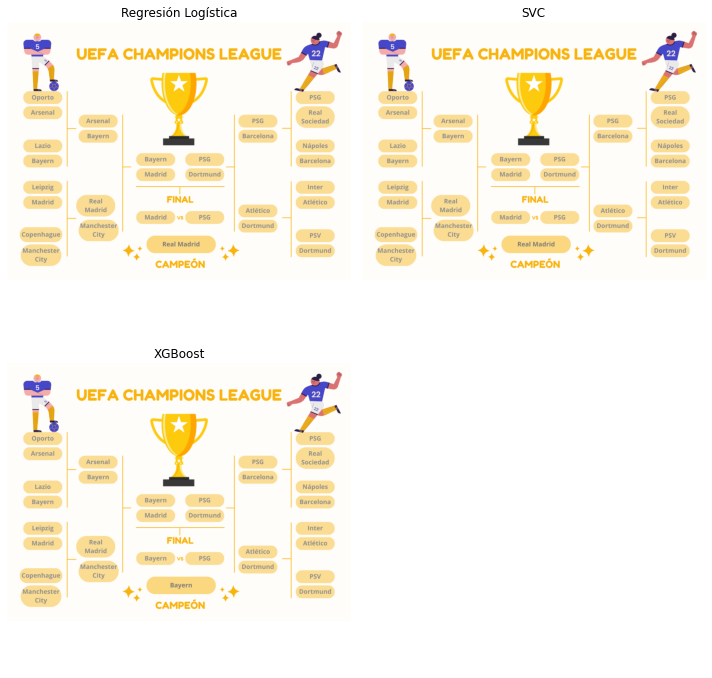

In [3]:
# Rutas de las imágenes
rutas_imagenes = ['../../img/clasificaciones/LR, SVC.png', '../../img/clasificaciones/LR, SVC.png', '../../img/clasificaciones/XGB.png']

# Títulos de las imágenes
titulos = ['Regresión Logística', 'SVC', 'XGBoost']

# Crear una figura y ejes
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Mostrar las imágenes y añadir títulos (primera fila)
for i in range(2):
    img = mpimg.imread(rutas_imagenes[i])
    axs[0, i].imshow(img)
    axs[0, i].set_title(titulos[i])
    axs[0, i].axis('off')

# Mostrar la imagen en la segunda fila
img = mpimg.imread(rutas_imagenes[2])
axs[1, 0].imshow(img)
axs[1, 0].set_title(titulos[2])
axs[1, 0].axis('off')

# Eliminar el espacio vacío del cuarto eje
axs[1, 1].axis('off')

# Ajustar el diseño y mostrar
plt.tight_layout()
plt.show()